# Parameterizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyqg
year = 24*60*60*360.

## Define parameterization

In this example, we'll implement the physical parameterization learned by symbolic regression in [Zanna and Bolton 2020](https://doi.org/10.1029/2020GL088376):

In [2]:
def zb2020_parameterization(m, factor=-46761284):
    """Implements the parameterization from Equation 6 of
    https://doi.org/10.1029/2020GL088376"""
    ik = 1j * m.k
    il = 1j * m.l
    
    # Compute relative velocity derivatives in spectral space
    uh = m.fft(m.u)
    vh = m.fft(m.v)
    vx = m.ifft(vh * ik)
    vy = m.ifft(vh * il)
    uy = m.ifft(uh * il)
    ux = m.ifft(uh * ik)
    
    # Compute ZB2020 basis functions
    rel_vort = vx - uy
    shearing = vx + uy
    stretching = ux - vy
    
    # Combine them in real space and take their FFT
    rv_stretch = m.fft(rel_vort * stretching)
    rv_shear = m.fft(rel_vort * shearing)
    sum_sqs = m.fft(rel_vort**2 + shearing**2 + stretching**2) / 2.0
    
    # Take spectral-space derivatives and multiply by the scaling factor
    Su = factor * m.ifft(ik*(sum_sqs - rv_shear) + il*rv_stretch)
    Sv = factor * m.ifft(il*(sum_sqs + rv_shear) + ik*rv_stretch)
    
    return Su, Sv

This function parameterizes subgrid forcing in terms of changes that should be applied to the real-space velocity tendencies. To use it in a `pyqg.Model`, we can pass it during initialization as `uv_parameterization`, and then its outputs will be added to the spectral-space potential vorticity tendency $\partial_t \hat{q}$ (after suitable transformations, and at each timestep).  Note that we can also define parameterizions in terms of PV directly by initializing the model with a `q_parameterization` function (which should return a single array rather than a tuple of two).

## Run models

To illustrate the effect of the parameterization, we'll run three variants of models:

* one without parameterization at `nx=64` resolution (where $\Delta x$ is larger than the deformation radius $r_d$, preventing the model from fully resolving eddies),

* one with parameterization at `nx=64` resolution,

* one at a higher `nx=256` resolution (where $\Delta x$ is ~4x finer than the deformation radius, so eddies can be almost fully resolved).

In [3]:
%%time
m_unparam = pyqg.QGModel(nx=64, dt=3600., tmax=10*year, tavestart=5*year, twrite=10000)
m_unparam.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.92e-05, CFL: 0.007
INFO: Step: 20000, Time: 7.20e+07, KE: 4.28e-04, CFL: 0.051
INFO: Step: 30000, Time: 1.08e+08, KE: 4.88e-04, CFL: 0.045
INFO: Step: 40000, Time: 1.44e+08, KE: 4.98e-04, CFL: 0.042
INFO: Step: 50000, Time: 1.80e+08, KE: 4.54e-04, CFL: 0.052
INFO: Step: 60000, Time: 2.16e+08, KE: 5.30e-04, CFL: 0.052
INFO: Step: 70000, Time: 2.52e+08, KE: 4.62e-04, CFL: 0.040
INFO: Step: 80000, Time: 2.88e+08, KE: 4.90e-04, CFL: 0.044


CPU times: user 20.4 s, sys: 70.4 ms, total: 20.5 s
Wall time: 20.7 s


In [4]:
%%time
m_param = pyqg.QGModel(nx=64, dt=3600., tmax=10*year, tavestart=5*year, twrite=10000,
                 uv_parameterization=zb2020_parameterization)
m_param.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.69e-05, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 3.78e-04, CFL: 0.047
INFO: Step: 30000, Time: 1.08e+08, KE: 4.27e-04, CFL: 0.043
INFO: Step: 40000, Time: 1.44e+08, KE: 3.65e-04, CFL: 0.039
INFO: Step: 50000, Time: 1.80e+08, KE: 4.37e-04, CFL: 0.048
INFO: Step: 60000, Time: 2.16e+08, KE: 4.26e-04, CFL: 0.045
INFO: Step: 70000, Time: 2.52e+08, KE: 3.90e-04, CFL: 0.040
INFO: Step: 80000, Time: 2.88e+08, KE: 3.94e-04, CFL: 0.047


CPU times: user 57.8 s, sys: 202 ms, total: 58 s
Wall time: 59 s


In [5]:
%%time
m_hires = pyqg.QGModel(nx=256, dt=3600., tmax=10*year, tavestart=5*year, twrite=10000)
m_hires.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 3.75e-06, CFL: 0.023
INFO: Step: 20000, Time: 7.20e+07, KE: 6.96e-04, CFL: 0.192
INFO: Step: 30000, Time: 1.08e+08, KE: 6.13e-04, CFL: 0.227
INFO: Step: 40000, Time: 1.44e+08, KE: 5.91e-04, CFL: 0.201
INFO: Step: 50000, Time: 1.80e+08, KE: 6.01e-04, CFL: 0.259
INFO: Step: 60000, Time: 2.16e+08, KE: 6.66e-04, CFL: 0.237
INFO: Step: 70000, Time: 2.52e+08, KE: 6.71e-04, CFL: 0.250
INFO: Step: 80000, Time: 2.88e+08, KE: 6.11e-04, CFL: 0.228


CPU times: user 5min 45s, sys: 1.12 s, total: 5min 46s
Wall time: 5min 50s


Note that parameterization does slow down the simulation, but it's still significantly faster than running a high-resolution simulation.

## Plot spectra

Now let's examine how adding the parameterization to our simulation changed its energetic properties:

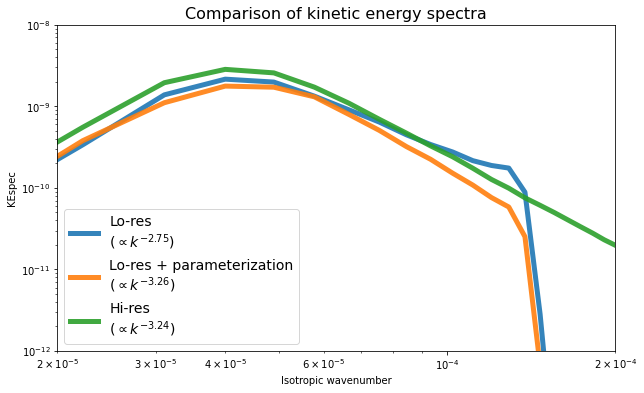

In [6]:
from pyqg import diagnostic_tools as tools
from scipy.stats import linregress

plt.figure(figsize=(10,6))

plt.title("Comparison of kinetic energy spectra", fontsize=16)

for m,label in zip([m_unparam, m_param,  m_hires], ['Lo-res','Lo-res + parameterization','Hi-res']):
    # Calculate the spectrum
    k, spectrum = tools.calc_ispec(m, m.get_diagnostic('KEspec').sum(axis=0))
    
    # Do a power law fit on data in the intertial range
    kmin = 5e-5
    kmax = 1e-4
    i = np.argmin(np.abs(np.log(k) - np.log(kmin)))
    j = np.argmin(np.abs(np.log(k) - np.log(kmax)))
    lr = linregress(np.log(k[i:j]), np.log(spectrum[i:j]))
    
    # Plot the spectrum with the linear fit
    loglog_plot = plt.loglog(k, spectrum, lw=5, alpha=0.9,
                             label=(label + "\n($\propto k^{" + str(lr.slope.round(2)) + "}$)"))
    
    
plt.ylim(1e-12, 1e-8)
plt.xlim(2e-5, 2e-4)
plt.xlabel("Isotropic wavenumber")
plt.ylabel("KEspec")
plt.legend(loc='best', fontsize=14)
plt.show()

Although the overall energy is lower, the parameterization ends up with an inverse cascade whose decay rate (log-log slope over intertial lengthscales) is much closer to that of the high-resolution model.